In [1]:
import scanpy as sc
import numpy as np
import scgen as scg
import pandas as pd
import sys
sys.path.append("/work/users/mh823zote/projects/cov/integration/analysis")
import helper_VAE as hVAE
import scipy.sparse
import scgen
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hpy
import anndata
import random

import os

/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Read in

In [2]:
species = 'ma'
celltype = 'Non_Classical_Monocytes'
model_save_string = os.getcwd()
model_save_string = model_save_string + '/' + celltype + '/H0_01_model_' + celltype + '.pt'
model = scgen.SCGEN.load(model_save_string)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 356 cells, 1059 vars, 5 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              


/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scvi/data/_anndata.py:301: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


## Train 

In [3]:
adata = model.adata
lat_adata = hVAE.get_latent_representation_object(model,adata)

#hVAE.prepare_umap(lat_adata)

#sc.pl.umap(lat_adata,color = 'timepoint')

D0 = hVAE.filter_adata_obs(lat_adata,col_name='timepoint',val='D0')
hd_D2 = hVAE.filter_adata_obs(lat_adata,col_name='timepoint',val='hd_D2')
hd_D3 = hVAE.filter_adata_obs(lat_adata,col_name='timepoint',val='hd_D3')
ld_D2 = hVAE.filter_adata_obs(lat_adata,col_name='timepoint',val='ld_D2')
ld_D2 = hVAE.filter_adata_obs(lat_adata,col_name='timepoint',val='ld_D2')

lat_adata = hVAE.merge_adata(hVAE.merge_adata(hVAE.merge_adata(hVAE.merge_adata(ld_D2,hd_D2),ld_D2),hd_D3),D0)

delta = hVAE.get_delta_in_latent_space(D0,hd_D2)
D0_shifted = hVAE.shift_adata_in_latent_space(D0,delta)
D0_shifted.obs['timepoint'] = 'hd_D2 predicted'

lat_all = hVAE.merge_adata(lat_adata,D0_shifted)

hVAE.prepare_umap(lat_all)

/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for co

# Test

In [5]:
test_set = sc.read_h5ad(celltype + '/H0_01_test_Non_Classical_Monocytes_.h5ad')
lat_adata_test = hVAE.get_latent_representation_object(model,test_set)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 258 cells, 1059 vars, 5 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              


/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scvi/data/_anndata.py:301: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [6]:
lat_D0_test = lat_adata_test[lat_adata_test.obs['timepoint'] == 'D0']

lat_D0_test_shifted = hVAE.shift_adata_in_latent_space(lat_D0_test,delta)

lat_D0_test_shifted.obs['timepoint'] = 'hd_D2 predicted'

lat_test_predicted = hVAE.merge_adata(lat_adata_test,lat_D0_test_shifted)

/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [7]:
hVAE.prepare_umap(lat_test_predicted)

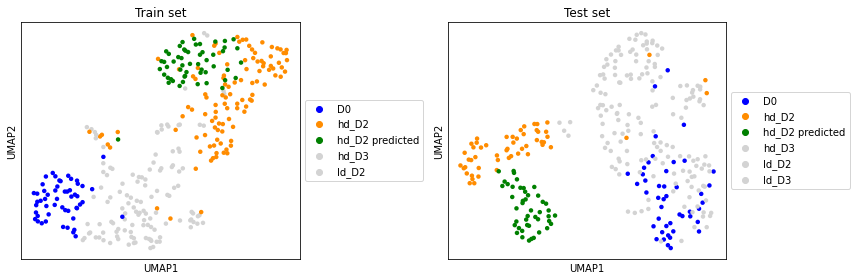

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


# Plot UMAP for 
color_palette_train = ['blue','#FF8C00','#008000','lightgrey','lightgrey','lightgrey']
point_size = np.ones(len(lat_all))
sc.pl.umap(lat_all,color = 'timepoint',ax = axes[0],palette = color_palette_train,size = point_size*80,show = False)
axes[0].set_title('Train set')
axes[0].legend(loc='center left',bbox_to_anchor=(1, 0.5))


color_palette_test = ['blue','#FF8C00','#008000','lightgrey','lightgrey','lightgrey']
point_size = np.ones(len(lat_test_predicted))
sc.pl.umap(lat_test_predicted,color = 'timepoint',ax = axes[1],palette = color_palette_test,size = point_size*80,show = False)
axes[1].set_title('Test set')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(celltype + '/H0_02_train_test_umap_pr_' + celltype + '.pdf',bbox_inches = 'tight')

# Decoding

In [11]:
decoded_test = hVAE.decode_latent_object(model,lat_test_predicted,test_set)

sc.tl.rank_genes_groups(decoded_test, groupby="timepoint", method="wilcoxon")
diff_genes = decoded_test.uns["rank_genes_groups"]["names"]["hd_D2 predicted"]

/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/sc.uni-leipzig.de/mh823zote/miniconda3/envs/scgen/lib/python3.9/site-packages/scan

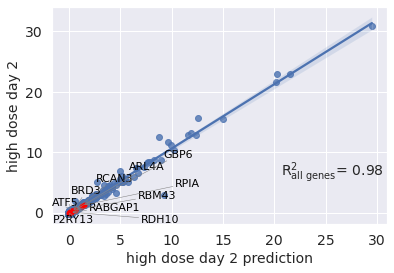

In [12]:
r2_value_hd_D2_hd_D2 = model.reg_mean_plot(
    decoded_test,
    axis_keys={"x": "hd_D2 predicted", "y": "hd_D2"},
    gene_list=diff_genes[:10],
    labels={"x": "high dose day 2 prediction", "y": "high dose day 2"},
    show=True,
    legend=False,
    path_to_save = celltype + '/H0_02_regmean_hd_D2_hd_D2_' + celltype + '.pdf'
)

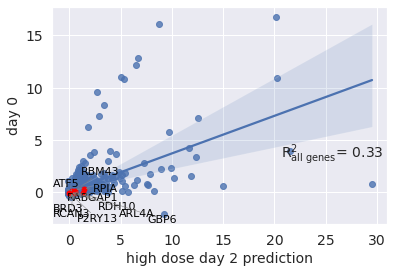

In [13]:
r2_value_hd_D2_D0 = model.reg_mean_plot(
    decoded_test,
    axis_keys={"x": "hd_D2 predicted", "y": "D0"},
    gene_list=diff_genes[:10],
    labels={"x": "high dose day 2 prediction", "y": "day 0"},
    show=True,
    legend=False,
    path_to_save = celltype + '/H0_02_regmean_hd_D2_D0_' + celltype + '.pdf'
)

# r2

In [14]:
r2_overview = pd.DataFrame([r2_value_hd_D2_hd_D2,r2_value_hd_D2_D0],
                 columns = [celltype],index = ['hd_D2 - hd_D2 predicited','D0 - hd_D2 predicted'])

r2_overview.to_csv(celltype + '/r2_val_HO_02_' + celltype + '.csv')